In [ ]:
#imports

import numpy as np
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import math
!matplotlib inlinex
np.random.seed(0)

/bin/bash: matplotlib: command not found


In [ ]:
#data load

from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


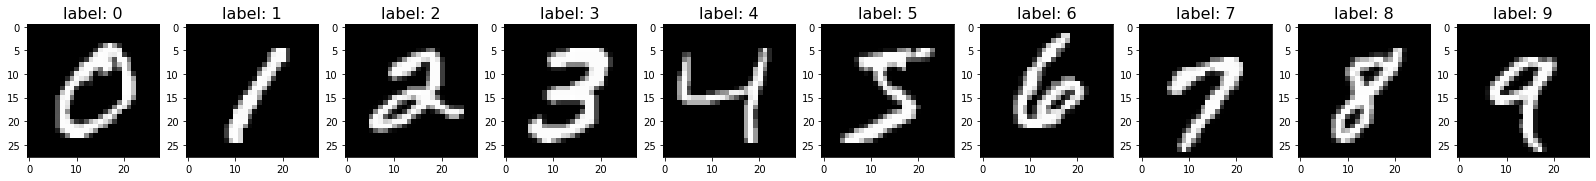

In [ ]:
#Visuailize Examples

num_classes = 10
f, ax = plt.subplots(1, num_classes, figsize=(28,28))
for i in range(0, num_classes):
  sample = train_images[train_labels == i][0]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("label: {}".format(i), fontsize=16)

In [ ]:
for i in range(num_classes):
  print(train_labels[i])

5
0
4
1
9
2
1
3
1
4


Prepare Data

In [ ]:
# Scale images to the [0, 1] range
train_images = train_images/255.0
test_images = test_images/255.0

# Make sure images have shape (28, 28, 1)
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)
print(train_images.shape, "train samples")
print(test_images.shape, "test samples")
print(train_images.shape[0], "train samples")
print(test_images.shape[0], "test samples")


# convert class vectors to binary class matrices
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)


(60000, 28, 28, 1) train samples
(10000, 28, 28, 1) test samples
60000 train samples
10000 test samples


In [ ]:
for i in range(num_classes):
  print(train_labels[i])


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
COMMITTEE_SIZE = 9
input_shape = (28,28,1)
print(train_images.shape, "train samples")
print(train_images.shape[0], "test samples")
do = train_images.shape[0] // (COMMITTEE_SIZE)
print(train_labels.shape)

train_mas = np.empty((COMMITTEE_SIZE, do, 28, 28, 1), dtype="float32")
labels_mas = np.empty((COMMITTEE_SIZE, do, 10), dtype="float32")

for i in range(COMMITTEE_SIZE):
   train_mas[i] = train_images[do*i:do * (i + 1)]
   labels_mas[i] = train_labels[do*i:do * (i + 1)]


(60000, 28, 28, 1) train samples
60000 test samples
(60000, 10)


In [ ]:
  # Average pictures
  av_pic_mas = np.zeros((COMMITTEE_SIZE, labels_mas.shape[2], 28, 28, 1))
  num_of_number = np.zeros((COMMITTEE_SIZE,labels_mas.shape[2]))
  for i in range(COMMITTEE_SIZE):
    for j in range(labels_mas.shape[1]):
      av_pic_mas[i][np.argmax(labels_mas[i][j])] += train_mas[i][j]
      num_of_number[i][np.argmax(labels_mas[i][j])] += 1
  print(num_of_number[0])
  for i in range(COMMITTEE_SIZE):
    for j in range(num_of_number.shape[1]):
      av_pic_mas[i][j] /= num_of_number[i][j]


       

[655. 749. 650. 685. 685. 579. 675. 717. 616. 665.]
<built-in method max of numpy.ndarray object at 0x7f4276115330>


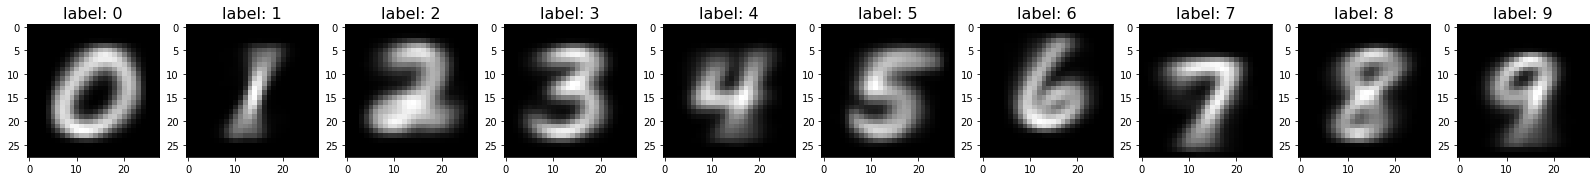

In [ ]:
#Visuailize average numbers
f, ax = plt.subplots(1, num_classes, figsize=(28,28))
for i in range(0, num_classes):
  sample = av_pic_mas[0][i]
  sample = np.squeeze(sample, axis=2)
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("label: {}".format(i), fontsize=16)


  # x = av_pic_mas[2][7]
  # x = np.squeeze(x, axis=2)
  # fig, ax = plt.subplots(1, 1)
  # ax.imshow(x, cmap='gray')
  # plt.show()


In [ ]:
# Add average pictures to datasets
av_pic_labels_mas = np.zeros((9, 10, 10), dtype=float)
for i in range(COMMITTEE_SIZE):
  av_pic_labels_mas[i] = np.eye(10)
train_mas = np.concatenate((train_mas, av_pic_mas), axis=1)
labels_mas = np.concatenate((labels_mas, av_pic_labels_mas), axis=1)
print(train_mas.shape)
print(labels_mas.shape)

(9, 6676, 28, 28, 1)
(9, 6676, 10)


In [ ]:
for i in range(COMMITTEE_SIZE):
  av_pic_labels_mas[i] = np.eye(10)
train_mas = np.concatenate((train_mas, av_pic_mas), axis=1)
labels_mas = np.concatenate((labels_mas, av_pic_labels_mas), axis=1)
print(train_mas.shape)
print(labels_mas.shape)

(9, 6696, 28, 28, 1)
(9, 6696, 10)


In [ ]:
def create_model():
  model = keras.Sequential(
      [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(512, activation="relu", input_shape=input_shape),
        layers.Dense(num_classes, activation="softmax"),
    ]
  )
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  return (model)


In [ ]:
models_mas = []
for i in range(COMMITTEE_SIZE):
  models_mas.append(create_model())
models_mas[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [ ]:
batch_size = 16
epochs = 15
for i in range(COMMITTEE_SIZE):
  #models_mas[i] = load_model('ski_neuro_ncd'+str(i)+'.h5')
#models_mas[0].summary()
  models_mas[i].fit(train_mas[i],labels_mas[i], batch_size=batch_size, epochs=epochs, validation_split=0.1)
  print("Fitting №", i+1, "COPMLETE!")


Epoch 1/15
377/377 [==============================] - 2s 4ms/step - loss: 0.0241 - accuracy: 0.9919 - val_loss: 0.0453 - val_accuracy: 0.9940
Epoch 2/15
377/377 [==============================] - 1s 4ms/step - loss: 0.0227 - accuracy: 0.9934 - val_loss: 0.0714 - val_accuracy: 0.9791
Epoch 3/15
377/377 [==============================] - 1s 4ms/step - loss: 0.0182 - accuracy: 0.9940 - val_loss: 0.0590 - val_accuracy: 0.9866
Epoch 4/15
377/377 [==============================] - 1s 4ms/step - loss: 0.0146 - accuracy: 0.9949 - val_loss: 0.0813 - val_accuracy: 0.9851
Epoch 5/15
377/377 [==============================] - 1s 4ms/step - loss: 0.0129 - accuracy: 0.9954 - val_loss: 0.0685 - val_accuracy: 0.9776
Epoch 6/15
377/377 [==============================] - 1s 4ms/step - loss: 0.0257 - accuracy: 0.9912 - val_loss: 0.0973 - val_accuracy: 0.9776
Epoch 7/15
377/377 [==============================] - 1s 4ms/step - loss: 0.0155 - accuracy: 0.9947 - val_loss: 0.1053 - val_accuracy: 0.9776
Epoch 

In [ ]:
# Evaluate
for i in range(COMMITTEE_SIZE):
  score = models_mas[i].evaluate(test_images, test_labels, verbose=0)
  print("Neuro №", i+1, ":")
  print("Test loss:", score[0])
  print("Test accuracy:", score[1],"\n")

Neuro № 1 :
Test loss: 0.07983744144439697
Test accuracy: 0.9783999919891357 

Neuro № 2 :
Test loss: 0.06758861988782883
Test accuracy: 0.9817000031471252 

Neuro № 3 :
Test loss: 0.06443553417921066
Test accuracy: 0.9836000204086304 

Neuro № 4 :
Test loss: 0.08074824512004852
Test accuracy: 0.9779000282287598 

Neuro № 5 :
Test loss: 0.05071113631129265
Test accuracy: 0.9836000204086304 

Neuro № 6 :
Test loss: 0.0782749205827713
Test accuracy: 0.9772999882698059 

Neuro № 7 :
Test loss: 0.06077966466546059
Test accuracy: 0.9829000234603882 

Neuro № 8 :
Test loss: 0.07873189449310303
Test accuracy: 0.978600025177002 

Neuro № 9 :
Test loss: 0.0724564865231514
Test accuracy: 0.9818999767303467 



In [ ]:
#create simple model
#simple_model = load_model('simple_neuro_ncd.h5')

bath_size = 128
simple_model = create_model()
simple_model.fit(train_images,train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
3375/3375 [==============================] - 12s 3ms/step - loss: 0.1507 - accuracy: 0.9524 - val_loss: 0.0456 - val_accuracy: 0.9860
Epoch 2/15
3375/3375 [==============================] - 12s 4ms/step - loss: 0.0649 - accuracy: 0.9793 - val_loss: 0.0408 - val_accuracy: 0.9878
Epoch 3/15
3375/3375 [==============================] - 14s 4ms/step - loss: 0.0500 - accuracy: 0.9844 - val_loss: 0.0435 - val_accuracy: 0.9883
Epoch 4/15
3375/3375 [==============================] - 11s 3ms/step - loss: 0.0397 - accuracy: 0.9869 - val_loss: 0.0325 - val_accuracy: 0.9900
Epoch 5/15
3375/3375 [==============================] - 12s 4ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0319 - val_accuracy: 0.9902
Epoch 6/15
3375/3375 [==============================] - 11s 3ms/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.0254 - val_accuracy: 0.9932
Epoch 7/15
3375/3375 [==============================] - 12s 4ms/step - loss: 0.0286 - accuracy: 0.9906 - val_loss: 0.0282 - val_ac

In [ ]:
# Evaluate simple model
score = simple_model.evaluate(test_images, test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.030462445691227913
Test accuracy: 0.9922000169754028


In [ ]:
# Save weights

from keras.models import load_model
from google.colab import files
for i in range(COMMITTEE_SIZE):
  models_mas[i].save('ski_neuro_512cd'+str(i)+'.h5')
  files.download('ski_neuro_512cd'+str(i)+'.h5')
%ls
simple_model.save('simple_neuro_512cd.h5')
files.download('simple_neuro_512cd.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

img.png              ski_neuro_512cd3.h5  ski_neuro_ncd0.h5  ski_neuro_ncd6.h5
sample_data/         ski_neuro_512cd4.h5  ski_neuro_ncd1.h5  ski_neuro_ncd7.h5
simple_neuro_ncd.h5  ski_neuro_512cd5.h5  ski_neuro_ncd2.h5  ski_neuro_ncd8.h5
ski_neuro_512cd0.h5  ski_neuro_512cd6.h5  ski_neuro_ncd3.h5
ski_neuro_512cd1.h5  ski_neuro_512cd7.h5  ski_neuro_ncd4.h5
ski_neuro_512cd2.h5  ski_neuro_512cd8.h5  ski_neuro_ncd5.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prepare the image for recognition
def prep4rec(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  img = cv2.bitwise_not(img)
  img = cv2.blur(img,(10,10))
  plt.imshow(img, cmap='gray')
  plt.show()
  img = cv2.resize(img, (28,28), interpolation= cv2.INTER_AREA)
  img = img / 255.0
  img = img.reshape(1, 28, 28, 1)
  return img

In [ ]:
# prepare the image for recognition without imshow
def prep4rec0(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  img = cv2.bitwise_not(img)
  img = cv2.resize(img, (28,28), interpolation= cv2.INTER_AREA)
  img = img / 255.0
  img = img.reshape(1, 28, 28, 1)
  return img

In [ ]:
# my predict
def my_predict(model, img):
  res = model.predict(img)
  print(np.argmax(res), np.max(res))
  plt.imshow(img.reshape(28,28), cmap='gray')
  plt.show()

In [ ]:
# my predict with unknown without imshow
UNKNOWN_LIMIT = 0.8
solutions_mas = np.full((COMMITTEE_SIZE), -1)
def my_predict0(model, img):
  res = model.predict(img)
  x = [np.argmax(res), np.max(res)]
  if (x[1] <= UNKNOWN_LIMIT):
    x[0] = 10
  return x

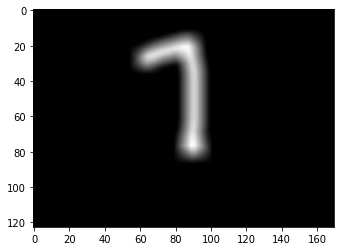

[1, 0.8599464]
[1, 0.88263136]
[10, 0.5668617]
[10, 0.74036103]
[10, 0.3130661]
[10, 0.3714926]
[10, 0.28603175]
[10, 0.5314789]
[10, 0.5345581]

 [10, 0.72982305]


In [ ]:
# get preditions
img = prep4rec("img.png")
for i in range(COMMITTEE_SIZE):
  buf = my_predict0(models_mas[i], img)
  solutions_mas[i] = buf[0]
  print(buf)
print("\n",my_predict0(simple_model, img))

In [ ]:
# checking for an absolute majority
print(solutions_mas)
UNDECIDED = np.sum(solutions_mas==10)
if(UNDECIDED >= math.ceil(COMMITTEE_SIZE/2)):
   print("THE ANSWER IS UNKNOWN")


[ 1  1 10 10 10 10 10 10 10]
THE ANSWER IS UNKNOWN


[2 3 4 5 6 7 8]
[1]


Миксуем  2 нейронку с ее средней: 1
[10, 0.1260781]


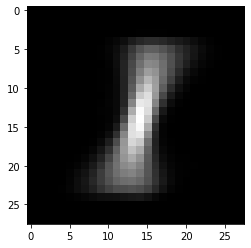



Миксуем  3 нейронку с ее средней: 1
[10, 0.16964029]


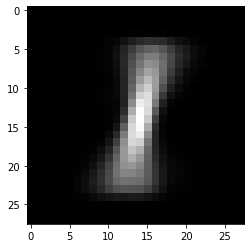



Миксуем  4 нейронку с ее средней: 1
[10, 0.17843467]


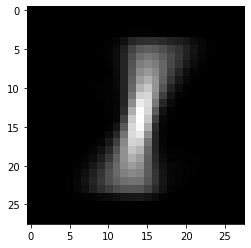



Миксуем  5 нейронку с ее средней: 1
[10, 0.13567658]


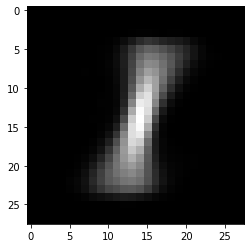



Миксуем  6 нейронку с ее средней: 1
[10, 0.16957638]


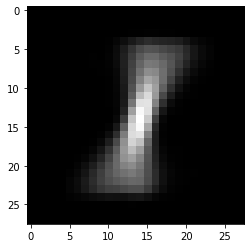



Миксуем  7 нейронку с ее средней: 1
[10, 0.21821094]


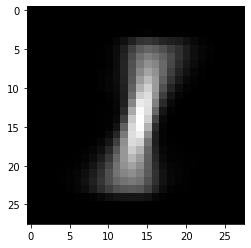



Миксуем  8 нейронку с ее средней: 1
[10, 0.15872984]


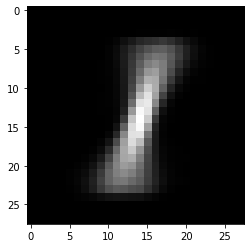

[ 1  1 10 10 10 10 10 10 10]


In [ ]:
K1 = 0/2
K2 = 1/2
experts_index = np.where(solutions_mas == 10)[0]
unique_val = np.unique(solutions_mas)[:-1]
print(experts_index)
print(unique_val)


for i in experts_index:
  prev_val = -1
  print('\n')
  for j in unique_val:
    img_buf = (K1*img) + (K2*av_pic_mas[i][j])
    img_buf /= 2
    print("Миксуем ", i, "нейронку с ее средней:", j)
    cur_pred = my_predict0(models_mas[i], img_buf)
    print(cur_pred)
    cur_val = cur_pred[1]
    if (cur_val < prev_val):
      cur_val = prev_val
    prev_val = cur_val
    solutions_mas[i] = cur_pred[0]
    plt.imshow(img_buf.reshape(28,28), cmap='gray')
    plt.show()
print(solutions_mas)

In [ ]:
# a = np.zeros((3))
# b = np.zeros((3))

# a=np.concatenate((a,b))

# print(a)
# print(solutions_mas)
# res = np.where(solutions_mas==10)
# res = res[0]
# print(res)


[ 2 10 10 10  2  2 10  7  2]
[1 2 3 6]


In [ ]:
# K1 = 1/3
# K2 = 2/3
# experts_mas = np.full((COMMITTEE_SIZE-UNDECIDED, COMMITTEE_SIZE), -1)
# print(experts_mas.shape)
# for k in range(COMMITTEE_SIZE-UNDECIDED):
#   print("K=",k,"\n")
#   for i in range(COMMITTEE_SIZE):
#     print("I=",i,"\n")
#     if (solutions_mas[i] != 10): # если сетка уверена в решение
#       experts_mas[k][i] = solutions_mas[i]
#       # перебираем тех, кто не уверен
#       for j in range(COMMITTEE_SIZE): 
#         print("j=",j,"\n")
#         if(solutions_mas[j] == 10):
#           #print("Nero UNDECIDED # ",j,"| MIXING IMG + ",solutions_mas[i])
#           img_buf = (K1*img) + (K2*av_pic_mas[j][solutions_mas[i]])
#           img_buf /= 2
#           buf = my_predict0(models_mas[j], img_buf)
#           print("Nero #",j," неуверенна | смешиваем входное IMG с ее средней ",solutions_mas[i], "| NEW PREDICT ", buf)
#           experts_mas[k][j] = buf[0]


# print(experts_mas) 
# print(img_buf.max())
# print(solutions_mas[3])
# img_buf = img_buf.reshape(1, 28, 28, 1)
# my_predict(models_mas[3],img_buf)



In [ ]:
# K1 = 1/3
# K2 = 2/3
# z=0
# opinion_mas = np.full((COMMITTEE_SIZE-UNDECIDED, COMMITTEE_SIZE), -1)
# print(opinion_mas.shape)
# for i in range(COMMITTEE_SIZE):
#   if(solutions_mas[i] !=10): #  если нейронка уверена
#     opinion_mas[][i] = solutions_mas[i]
#     for j in range(COMMITTEE_SIZE):
#       if(solutions_mas[j] == 10):
#         z =z+1
#         img_buf = (K1*img) + (K2*av_pic_mas[j][solutions_mas[i]])
#         img_buf /= 2
#         buf = my_predict0(models_mas[j], img_buf)
#         opinion_mas[k][j] = buf[0]
# #    elif(solutions_mas[i] == 10): # если нейронка не знает
# #       print(solutions_mas[i])
# #       img_buf = (K1*img) + (K2*av_pic_mas[i][solutions_mas[i]])
# #       img_buf /= 2
# #       buf = my_predict0(models_mas[j], img_buf)
# #       opinion_mas[k][i] = buf[0]
# print(opinion_mas)
# print(z)

(5, 9)
[[ 2 10  2  2  2  2 10  7  2]
 [ 2 10  2  2  2  2 10  7  2]
 [ 2 10  2  2  2  2 10  7  2]
 [ 2 10  2  2  2  2 10  7  2]
 [ 2 10  2  2  2  2 10  7  2]]
100


In [ ]:
new_solutions_list = []
new_solutions_list.append(2)
new_solutions_list.append(3)
new_solutions_list.append(5)
print(new_solutions_list[0])

2


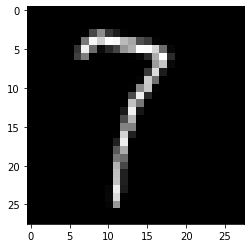

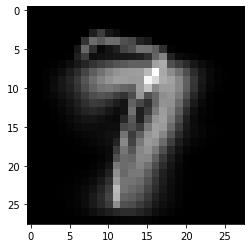

(1, 28, 28, 1)
(1, 28, 28, 1)


In [ ]:
  img = cv2.imread('img.png',cv2.IMREAD_GRAYSCALE)
  
  img = cv2.bitwise_not(img)
  x = av_pic_mas[7][7]
  img = cv2.resize(img, (28,28), interpolation= cv2.INTER_AREA)
  plt.imshow(img, cmap='gray')
  plt.show()
  img = img / 255.0

  x = x.reshape(28,28)
  img = ((1/3)*img) + ((2/3)*x)
  img = img / 2
  plt.imshow(img, cmap='gray')
  plt.show()

  x = x.reshape(1, 28, 28, 1)
  img = img.reshape(1, 28, 28, 1)
  print(img.shape)
  print(x.shape)

[7, 0.35948396]
[7, 0.2898711]
[7, 0.39324167]
[7, 0.40054727]
[7, 0.34686914]
[7, 0.31007156]
[7, 0.3602128]
[7, 0.348804]
[7, 0.38282982]
7 0.2978047


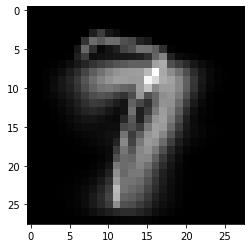


 None


In [ ]:
for i in range(COMMITTEE_SIZE):
  print(my_predict0(models_mas[i], img))
print("\n",my_predict(full_model, img))